**DATA ANALYSIS**

In [1]:
import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE') #change this to the folder where the data set is stored, all the results will be saved in the same folder
os.getcwd()

'C:\\Users\\justu\\Desktop\\Masterarbeit\\Data\\CE'

**Prepare Data** (necessary for part1 and part2)

In [12]:
fs08 = pd.read_csv(os.getcwd()+'\\fs08.csv').set_index('CustID')

#identifier
TIME = ['QINTRVMO', 'QINTRVYR', 'rbtmo_1', 'rbtmo_2', 'diff_1', 'diff_2']
ID = ['NEWID']

#dependent variables
CONS = ['FD','SND','ND','DUR','TOT']
FUTCONS = ['fut_' + c for c in CONS]
LRUNCONS = ['lrun_' + c for c in CONS]

for i in range(len(LRUNCONS)):
    fs08[LRUNCONS[i]] = fs08[[CONS[i],FUTCONS[i]]].sum(axis=1)

#explanatory variables
DEMO = ['age', 'adults', 'PERSLT18', 'MARITAL1', 'CUTENURE', 'FINCBTAX'] 
    #age; number of adults; people below 18; marital status; housing tenure; income in the last 12 months
DEMO2 = ['FSALARYM', 'FINCBTXM'] 
    #FSALARYM: income from salary and wages, CKBKACTX: balance/market value in balance accounts/brookerage accounts;    
    #FINCBTXM: Total amount of family income before taxes (Imputed or collected data); (relevant demographics available for the second stimulus only)
ASSETS = ['valid_finassets','finassets']
    # finassets: sum of 1) SAVACCTX (Total balance/market value (including interest earned) CU had in savings accounts in banks, savings and loans,
                         #credit unions, etc., as of the last day of previous month;)
                # and    2)CKBKACTX (Total balance or market value (including interest earned) CU had in checking accounts, brokerage accounts, 
                            #and other similar accounts as of the last day of the previous month
MORTGAGE = ['morgpayment', 'qblncm1x_sum', 'orgmrtx_sum', 'qescrowx_sum', 'timeleft']
    #morgpayment: morgage payment per month; qblncm1x_sum: sum of principal balances outstanding at the beginning of month M1; orgmrtx_sum: sum of mortgage amounts;
    #qescrowx_sum: sum of last regular escrow payments; timeleft: maximum time left on mortgage payment
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #
#sample split
RBT = ['rbtamt', 'rbtamt_chk', 'rbtamt_e']
LAGRBT = ['last_' + var for var in RBT] #lagged variables
FUTRBT = ['fut_' + var for var in RBT] #future variables

fs08 = fs08[TIME + ID + CONS + DEMO + DEMO2 + ASSETS + MORTGAGE + RBT + ['rbtamt_1','rbtamt_2'] + LAGRBT + FUTRBT + FUTCONS + LRUNCONS + EDUC] #+ CHGCONS + LAGCONS 
fs08 = pd.get_dummies(fs08, columns=['CUTENURE','MARITAL1']) #change categorical variables to dummy variables

DEMO = [s for s in DEMO if s!='CUTENURE' if s!='MARITAL1'] + ['CUTENURE' + f'_{j}' for j in list(range(1,6)) if j!=3] +['MARITAL1' + f'_{j}' for j in list(range(1,5))]

['age', 'adults', 'PERSLT18', 'FINCBTAX', 'CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5', 'MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4']


In [3]:
print(fs08['FINCBTAX'].corr(fs08['FINCBTXM']))
print(fs08['FSALARYM'].corr(fs08['FINCBTXM']))
print(fs08['FSALARYM'].corr(fs08['FINCBTAX']))
print(fs08['FINCBTAX'].corr(fs08['morgpayment']))
print(fs08.loc[(fs08['rbtamt']>0)&(fs08['valid_finassets']>0),'NEWID'].count())
print(fs08.loc[fs08['rbtamt']>0,'NEWID'].count())
fs08.loc[fs08['rbtamt_2']>0, ['rbtamt_1','rbtamt_2','diff_2', 'diff_1']]
fs08['diff'] = np.nan
fs08['diff'] = np.where((fs08['diff_1']>0) & (fs08['diff_2']>0), fs08[['diff_1','diff_2']].mean(axis=1),fs08['diff_1'])

0.8287701228524802
0.8955169267751125
0.7627057548315713
0.09380920937886113
771
4339


Generate the average rebate amount per individual 

In [4]:
fs08['rbtamt_idmean'] = 0
fs08['rbtamt_idmean'] = fs08.groupby('CustID')['rbtamt'].transform('mean')
fs08['rbt_count'] = 0
fs08['rbt_count'] = fs08.groupby('CustID')['rbtamt'].transform('count')

#
#sometimes individuals give information of rebate receipt preceding (following) three months of the first (last) interview.
#Wherever this is the case, the average rebate should be the weighted mean of rebates received before (after) the relevant time and the actual rebate 

fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())),
                                 1/(1+fs08['rbt_count'])*(fs08['last_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean,  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist() # & (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first') #change for all entries for a given individual


fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 1/(1+fs08['rbt_count'])*(fs08['fut_rbtamt']+fs08['rbtamt_idmean']), fs08['rbtamt_idmean']) #weighted mean  & (fs08['rbtamt_idmean']>0)
index = fs08.index[(fs08['fut_rbtamt']>0)  & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #& (fs08['rbtamt_idmean']>0)
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')  #change for all entries for a given individual
#display(fs08.loc[index, ['rbtamt_idmean', 'rbtamt', 'fut_rbtamt', 'last_rbtamt']])

#wherever there is no entry for rebates received in the relevant time period but when there were rebates receivde in the past (future) change mean to the value
index = fs08.index[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last()))].tolist() #                                                                               
fs08['rbtamt_idmean'] = np.where((fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].last())),
                                 fs08['fut_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('last')

index = fs08.index[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first()))].tolist()
fs08['rbtamt_idmean'] = np.where((fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()) & (fs08['NEWID'].isin(fs08.groupby('CustID')['NEWID'].first())), 
                                fs08['last_rbtamt'], fs08['rbtamt_idmean'])
fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('first')


fs08['rbt_flag'] = 0 
fs08.loc[(fs08['rbtamt']>0) | (fs08['fut_rbtamt']>0) | (fs08['last_rbtamt']>0) ,'rbt_flag'] = 1
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('sum')
fs08.loc[fs08['rbt_flag']>0, 'rbt_flag'] = 1
fs08 = fs08.loc[fs08['rbt_flag']==1]


index = fs08.index[fs08['rbtamt_idmean'].isna()].tolist()
index = list(set(index))
fs08.loc[index, 'rbtamt_idmean'] = fs08.loc[index,'fut_rbtamt']
fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['fut_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'fut_rbtamt' ]
fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'rbtamt_idmean' ] = fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt_idmean'].isna()), 'last_rbtamt' ]

fs08.loc[index,'rbtamt_idmean'] = fs08.loc[index,:].groupby('CustID')['rbtamt_idmean'].transform('mean')


Drop observations, impute values for financial liquidity

In [5]:

for i in range(len(RBT)):
    fs08.loc[fs08[RBT[i]]==0, RBT[i]] = np.nan
    fs08.loc[fs08[LAGRBT[i]]==0, LAGRBT[i]] = np.nan
    fs08.loc[fs08[FUTRBT[i]]==0, FUTRBT[i]] = np.nan
    #fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna()), LAGRBT[i]] =  fs08.loc[(fs08[LAGRBT[i]]==0) | (fs08[LAGRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 
    fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna()), FUTRBT[i]] =  fs08.loc[(fs08[FUTRBT[i]]==0) | (fs08[FUTRBT[i]].isna())].groupby('CustID')[RBT[i]].shift(-1) 



fs08 = fs08.reset_index()

#Iterative imputation for financial liquidity
#explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer


fs08 = fs08.dropna(subset=CONS+DEMO+DEMO2+MORTGAGE) #Keep only observations that have all info on explanatory variables, dropping missing values on mortgage lowers the sample to half 


fs08_finit = fs08.copy()
fs08_finit = fs08_finit[ ID + CONS + DEMO + DEMO2 + ASSETS + MORTGAGE +  LRUNCONS + EDUC]
#fs08_finit = fs08_finit.loc[:,CONS+DEMO+DEMO2+MORTGAGE+['CustID','NEWID','finassets']]
labels = list(fs08_finit.columns)
imp_mean = IterativeImputer(random_state=0) #use python package iterative imputer
imp_mean.fit(fs08_finit[2:])
fs08_finit = pd.DataFrame(imp_mean.transform(fs08_finit),columns=labels)
fs08_finit = fs08_finit.loc[:,['finassets','NEWID']]
fs08_finit = fs08_finit.rename(columns={'finassets':'finassets_it'})

fs08 = pd.merge(fs08.sort_values(by = ['NEWID']).reset_index(), fs08_finit.sort_values(by = ['NEWID']).reset_index(), how = 'left', on = 'NEWID', validate = '1:1')
fs08 = fs08.drop(columns=['index_x','index_y']) 
ASSETS = ['valid_finassets','finassets', 'finassets_it' ]


Generate treatment and control groups

In [6]:
#generate treatment group:
fs08['treat1'] = 0 
fs08.loc[fs08['rbtamt'].notna(),'treat1'] = 1 #all entries with actual info on rebate are in the treatment group

#three different control groups:
#control group 1: those who didn't receive the rebate in the given month
fs08['cont1'] = 0
fs08.loc[fs08['rbtamt'].isna(), 'cont1'] = 1

#control group 2: drop one time period after receipt of rebate, as part of rebate might've been consumed one time period after
fs08['cont2'] = 0 
fs08['rbt_flag'] = 0 
fs08.loc[fs08['rbtamt']>0,'rbt_flag'] = 1 #identifier for rebate
fs08['rbt_flag_lag'] = fs08.groupby('CustID')['rbt_flag'].shift(1) #identifier for rebate a period before (lag)
fs08.loc[fs08['rbt_flag_lag']==1,'rbt_flag']=1 #change rebate identifier so it capture now if a rebate was received this period or the period before
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0), 'cont2'] = 1 #those who didn't receive a rebate now or a period before are in the control group

#treatment 2: all individuals who received a rebate last time period. This group should be compared to control group 2 only
fs08['treat2'] = 0
fs08.loc[(fs08['cont2']==0) & (fs08['treat1']==0),'treat2'] = 1
fs08.loc[(fs08['last_rbtamt']>0) & (fs08['rbtamt'].isna()), 'treat2'] = 1

#treatment 3: long run consumption response: all individuals who received a rebate in this period and where the rebate interview is not the last
fs08['treat3'] = 0
fs08.loc[(fs08['rbtamt']>0) & (fs08[FUTCONS[0]].notna()), 'treat3'] = 1

#control 3: long-run consumption: those who haven't received a rebate two periods from current period and have information on consumption for next period as well
fs08['cont4'] = 0
fs08.loc[(fs08['cont2']==1) & (fs08[FUTCONS[0]].notna()),'cont4'] = 1

#control 4: those who haven't received the rebate yet
fs08['cont3'] = 0 
fs08['rbt_flag'] = fs08.groupby('CustID')['rbt_flag'].transform('cumsum') #starts counting from the point on which the first rebate was received
fs08.loc[(fs08['rbtamt'].isna()) & (fs08['rbt_flag']==0),'cont3'] = 1 

Drop observations

In [7]:
fs08_cap = fs08[(np.abs(stats.zscore(fs08.loc[:,CONS+LRUNCONS])) < 3).all(axis=1)] #drop outliers
fs08_cap = fs08_cap.loc[fs08_cap['FD']>0] #there are still two observations where food consumption is zero; drop bc of common sense

**Part 1: Descriptive statistics** (part 1 and part 2 cn be run seperately)

1.2 Take a look at the explanatory variables used for random forest algorithm

In [8]:
print('Whole sample (capped):')
print(DEMO[0])
expvars = DEMO+DEMO2+ASSETS+MORTGAGE+EDUC
for exp in expvars:
    if exp == DEMO[0]:
        des = fs08_cap.loc[fs08_cap['treat1']==1,exp].describe()
        display(des)
        des = pd.concat([des, fs08_cap.loc[fs08['cont1']==1,exp].describe()], axis=1, join='inner')
    else:
        pass
        for g in ['treat1','cont1']:
            des = pd.concat([des, fs08_cap.loc[fs08[g]==1,exp].describe()], axis=1, join='inner')
#index1 = [DEMO*2+DEMO2*2+ASSETS*2+MORTGAGE*2+EDUC*2
index1 = [ i for i in expvars for reps in range(2) ]
index2 = ['treat1','cont1']*25
tuples = list(zip(index1,index2))
des.columns = pd.MultiIndex.from_tuples(tuples) 
des_cols = list(des)
des_cols=[i for i in des_cols if i[0] in ['FINCBTAX','FSALARYM', 'FINCBTXM','finassets','finassets_it']]
print(des.to_latex(float_format="{:,.0f}".format, columns=des_cols,multicolumn_format='c'))

Whole sample (capped):
age


count    1941.000000
mean       46.505152
std        12.354085
min        21.000000
25%        37.000000
50%        46.000000
75%        55.000000
max        84.500000
Name: age, dtype: float64

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{FINCBTAX} & \multicolumn{2}{c}{FSALARYM} & \multicolumn{2}{c}{FINCBTXM} & \multicolumn{2}{c}{finassets} & \multicolumn{2}{c}{finassets\_it} \\
{} &   treat1 &    cont1 &   treat1 &   cont1 &   treat1 &   cont1 &    treat1 &     cont1 &       treat1 &     cont1 \\
\midrule
count &    1,941 &    5,446 &    1,941 &   5,446 &    1,941 &   5,446 &       344 &       728 &        1,941 &     5,446 \\
mean  &   67,099 &   67,390 &   72,060 &  70,776 &   81,479 &  81,045 &    40,343 &    37,520 &       37,775 &    38,583 \\
std   &   52,023 &   50,843 &   53,364 &  50,394 &   54,095 &  50,731 &   188,758 &   167,181 &       88,764 &    76,242 \\
min   &  -56,860 & -104,854 &        0 &       0 &  -36,146 & -36,146 &         0 &         0 &      -91,991 &  -154,508 \\
25\%   &   32,000 &   32,756 &   38,000 &  37,591 &   46,180 &  46,527 &       686 &       800 &        5,496 &     7,753 \\
50\%   &   61,100 &   62,000 &   64,799 &  6

In [9]:
print('Average amount of rebate received per household')
des = fs08_cap.loc[fs08_cap['cont1']==1,'rbtamt_idmean'].describe()
des = pd.concat([des, fs08_cap.loc[fs08_cap['treat1']==1,'rbtamt_idmean'].describe()], axis=1, join='inner',names=['cont1','treat1'])
des = pd.concat([des, fs08_cap.loc[fs08['rbtamt']>0,'rbtamt'].describe()], axis=1, join='inner',names=['cont1','treat1','treat1'])
tuples = [('rbtamt_mean', 'cont1'), ('rbtamt_mean', 'treat1'), ('rbtamt', 'treat1')]
des.columns = pd.MultiIndex.from_tuples(tuples)
print(des.stack().unstack(level=0).stack(level=0).to_latex(float_format="{:,.0f}".format,  columns=['count','mean','max','min','25%','75%','std']))
#print(des1.loc[['count', 'mean', 'std', 'min','50%','max'],:].to_latex(float_format="{:,.1f}".format))


Average amount of rebate received per household
\begin{tabular}{llrrrrrrr}
\toprule
       &             &  count &  mean &   max &  min &  25\% &   75\% &  std \\
\midrule
cont1 & rbtamt\_mean &  5,446 & 1,108 & 3,660 &    6 &  600 & 1,500 &  528 \\
treat1 & rbtamt &  1,941 & 1,095 & 3,660 &    1 &  600 & 1,500 &  527 \\
       & rbtamt\_mean &  1,941 & 1,097 & 3,660 &    6 &  600 & 1,500 &  521 \\
\bottomrule
\end{tabular}



1.1 Descriptives for dependent variable

In [10]:
print('summary stats for full sample on consumption:')
print(fs08[CONS].describe())
#print(fs08[CONS].describe().to_latex())
print('summary stats for capped sample on consumption:')
print(fs08_cap[CONS].describe().to_latex(float_format="%.2f" ))

treat = ['treat1','treat2','treat3']
cont = ['cont1','cont2','cont3','cont4']
#baseline:
CONS=['FD','SND','ND','TOT']
treat = ['treat1']
cont = ['cont1']

for i in CONS:
    if i=='FD':
        des = fs08_cap.loc[fs08_cap['treat1']==1,i].describe()
        des = pd.concat([des,fs08_cap.loc[fs08_cap['cont1']==1,i].describe()],join='inner',axis=1)
    else:
        for g in ['treat1','cont1']:
            des = pd.concat([des, fs08_cap.loc[fs08_cap[g]==1,i].describe()],join='inner', axis=1)

index1 = ['FD']*2 + ['SND']*2 + ['ND']*2 + ['TOT']*2
index2 = ['treat1','cont1']*8
tuples = list(zip(index1,index2))
des.columns = pd.MultiIndex.from_tuples(tuples)
print(des.to_latex(float_format="{:,.1f}".format ,multicolumn_format='c'))
des.stack().unstack(level=0).stack(level=0)

summary stats for full sample on consumption:
                 FD           SND            ND           DUR           TOT
count   7901.000000   7901.000000   7901.000000   7901.000000   7901.000000
mean    2214.125173   5107.249167   6357.100416   6241.762099  12598.862515
std     1309.135172   2681.752964   3277.032339   5821.221010   7599.242540
min        0.000000    611.000100  -4420.575000    169.499900   1818.500100
25%     1371.000000   3415.000200   4204.999800   3099.000200   7865.991000
50%     1975.000200   4620.750200   5761.999900   4756.000200  10843.200100
75%     2750.000100   6157.000000   7722.000200   7262.999900  14921.999800
max    37678.000300  50375.052100  54477.052200  90264.999900  98775.000000
summary stats for capped sample on consumption:
\begin{tabular}{lrrrrr}
\toprule
{} &      FD &      SND &       ND &      DUR &      TOT \\
\midrule
count & 7387.00 &  7387.00 &  7387.00 &  7387.00 &  7387.00 \\
mean  & 2076.57 &  4790.18 &  5969.59 &  5369.43 & 11339.

25%          50%          75%   count         max  \
cont1  FD   1331.250150   1919.00015   2600.00010  5446.0   6133.9998   
       ND   4092.000050   5527.49980   7259.87500  5446.0  15994.1336   
       SND  3296.000150   4411.00010   5820.79380  5446.0  12905.0000   
       TOT  7635.250075  10244.62525  13905.44955  5446.0  35115.3056   
treat1 FD   1399.999900   1985.00010   2740.00020  1941.0   5986.0000   
       ND   4259.500100   5877.00000   7784.49970  1941.0  15849.0002   
       SND  3569.000100   4815.00000   6267.00010  1941.0  12854.9998   
       TOT  7845.000100  10973.00020  14561.50000  1941.0  34784.6310   

                    mean        min          std  
cont1  FD    2049.654607    51.9999   976.803289  
       ND    5877.364805   940.0001  2443.192098  
       SND   4694.441266   675.9999  1911.486019  
       TOT  11203.336221  1818.5001  4941.313979  
treat1 FD    2152.072131    78.0000  1042.759107  
       ND    6228.362786   876.2501  2644.063350  
       SND   5058.814060   611.0001  2074.626364  
       TOT  11719.734302  2415.0002  5150.980866

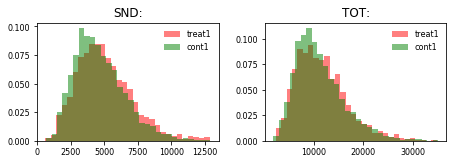

In [11]:
#compare histograms of treatment group with different control groups

for i in range(len(CONS)):
    for t in treat[0:1]:
        for c in cont[0:1]:
            plt.figure(figsize=(3.2,2.4))
            plt.title(f'{CONS[i]}')
            plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            #plt.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='red')
            plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            #plt.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= t, density=True, bins=30, color='green')
            #plt.set_title(f'{CONS[i]}:')
            #plt.tight_layout()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize=6)
            plt.legend(loc='upper right', frameon=True, fontsize=6)
            plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern.pdf')
            plt.close()
CONS=['SND','TOT']
fig=plt.figure(figsize=(6.4,2.4))
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    plot = plt.subplot(1,2,i+1)
    for t in treat[0:1]:
        for c in cont[0:1]:     
            #plot = plt.figure(figsize=(10,3))
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            plot.set_title(f'{CONS[i]}:')
            plt.tight_layout()
            plt.xticks(fontsize = 8)
            plt.yticks(fontsize=8)
            plt.legend(loc='upper right', frameon=False, fontsize=8)
            #plot_count = plot_count+1
            plt.savefig(os.getcwd() + f'\\descriptives\\SND_TOT_pattern_group1_treat1.pdf')
plt.close()


CONS=['FD','SND','ND','TOT']        
plot_count = 1
for i in range(len(CONS)):
    #plt.figure(figsize=(6.4,2.4))
    for t in treat[0:1]:
        fig=plt.figure(figsize=(6.4,2.4))
        for c in cont[0:3]:     
            #plot = plt.figure(figsize=(10,3))
            plot = plt.subplot(1,3,cont.index(c)+1)
            plot.hist(fs08_cap.loc[fs08_cap[t]==1,CONS[i]], alpha=0.5, label= t, weights=np.ones(len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[t]==1,CONS[i]]), bins=30, color='red')
            plot.hist(fs08_cap.loc[fs08_cap[c]==1,CONS[i]], alpha=0.5, label= c, weights=np.ones(len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]])) / len(fs08_cap.loc[fs08_cap[c]==1,CONS[i]]), bins=30, color='green')
            plot.set_title(f'{CONS[i]}:')
            plt.tight_layout()
            plt.legend(loc='upper right', frameon=False)
            plot_count = plot_count+1
            #plt.savefig(os.getcwd() + f'\\descriptives\\{CONS[i]}_pattern_groupcomp.pdf')
        plt.close()



descriptives for rebate:

**Part 2: Machine learning approach**

**2.1** Define sample 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle

In [15]:
EDUC = ['educ_nodegree','educ_highschool','educ_higher'] #'educ_bachelor','educ_master','educ_doctorate'
DEMO = ['age', 'adults', 'PERSLT18', 'FINCBTAX', 'CUTENURE_1', 'CUTENURE_2', 'CUTENURE_4', 'CUTENURE_5', 'MARITAL1_1', 'MARITAL1_2', 'MARITAL1_3', 'MARITAL1_4'] 
DEMO2 = ['FSALARYM', 'FINCBTXM' ] 
CONS = ['FD', 'SND', 'ND', 'TOT']
CONT = ['cont1', 'cont2', 'cont3']
TREAT = 'treat1'
treatgroup = TREAT
trees = 1000

#Random Forest for short term consumption: treatment group 1 with imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC + ['finassets_it']  #define explanatory variables + ['finassets_it'] 
#contgroup = CONT[3]
treatgroup = TREAT

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[fs08_cap[con]==1, [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_finit_baseline.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

#Random Forest for short term consumption: treatment group without imputations of financial assets
expvars = DEMO + DEMO2 + MORTGAGE + EDUC  #define explanatory variables + ['finassets_it'] 

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[fs08_cap[con]==1, [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_nofin_baseline.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

#Random Forest for short term consumption: treatment group with just the observations where financial assets are included
TREAT = 'treat1'
expvars = DEMO + DEMO2 + MORTGAGE + ['finassets'] + EDUC  #define explanatory variables + ['finassets_it'] 
#contgroup = CONT[3]
treatgroup = TREAT

for c in CONS:
    rf = dict()
    depvar = c
    treat = fs08_cap.loc[(fs08_cap[treatgroup]==1) & (fs08_cap['valid_finassets']==1), [depvar] + expvars + ['rbtamt_idmean']]
    rf[TREAT] = treat
    for con in CONT:
        cont = fs08_cap.loc[(fs08_cap[con]==1) & (fs08_cap['valid_finassets']==1) , [depvar] + expvars + ['rbtamt_idmean']]
        rf[con] = cont
    for i in (list(rf)):
        y = np.array(rf[i][depvar]) #array for dependent variable
        X = np.array(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1)) #array with relevant explanatory variables as columns
        rf[i+'_X'] = X #save as dict entry with keyword treat_X/cont_X
        X_labels = list(rf[i].drop([depvar ,'rbtamt_idmean'], axis=1).columns) #column labels as list
        rf[i+'_X_labels'] = X_labels #save in dict
        rf[i+'_rbtamt'] = np.array(rf[i]['rbtamt_idmean'])
        rf[i+'_rf'] = RandomForestRegressor(n_estimators = trees, random_state = 0, min_samples_leaf = 5, oob_score=True, max_features = 0.33)
        rf[i+'_rf'].fit(X,y)
    output = open(os.getcwd() + f'\\rf_dicts\\{depvar}_fin_baseline.pkl', 'wb')
    pickle.dump(rf, output)
    output.close()

**2.2** Run random forest algorithm seperately for treatment and control group

In [14]:
## read python dict back from the file
#pkl_file = open('myfile.pkl', 'rb')
#rf2 = pickle.load(pkl_file)
#pkl_file.close()
#
#print(rf)
#print(rf2)

**2.3** Predict Outcomes for overall consumption

In [16]:
def uplift_predicitons_rbt(rf_treat, rf_cont, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[], feature_ids_treat=[], feature_ids_cont=[]):
    
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if (type(X_cont) is not np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(X_treat_rbtamt) is not np.ndarray):
                raise ValueError('X_treat_rbamt needs to have an array like structure')
            else:
                X_temp = X_treat.copy()
                rbtamt_temp = X_treat_rbtamt.copy()
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(X_cont_rbtamt) is not np.ndarray):
                raise ValueError('if X_cont is specified, X_cont_rbamt needs to have an array like structure')
            if sorted(feature_ids_treat)!=sorted(feature_ids_cont):
                raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont')
            elif (len(feature_ids_treat)==0) | (len(feature_ids_cont)==0):
                raise ValueError(f'if X_treat and X_cont are specified, feature_ids must not be empty')
            else:
                X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                rbtamt_temp = pd.concat([pd.DataFrame(X_treat_rbtamt), pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                X_labels = list(X.columns)
                X_temp = np.array(X)
                rbtamt_temp = np.array(rbtamt_temp)
        else: 
            raise ValueError('X_treat does not have an array like structure')
        y = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
        mpc = y/rbtamt_temp[:,0]
        return y,mpc


In [17]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

In [18]:
rfdicts_keys = list(rfdicts)


for k in rfdicts_keys:
    print(f'{k}:')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\condistr\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for t in treat:
        for c in cont:
            y,mpc = uplift_predicitons_rbt(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                          rfdicts[k][c+'_X'],rfdicts[k][c+'_rbtamt'],rfdicts[k][t+'_X_labels'],rfdicts[k][c+'_X_labels'])
            rfdicts[k][f'{c}_{t}_y_pred'] = y
            print(f'{c}_{t}_y_pred', y.shape)
            rfdicts[k][f'{c}_{t}_mpc_pred'] = mpc
            print(f'{c}_{t}_mpc_pred', mpc.shape)
            plt.hist(y, bins=40,  edgecolor='black')
            lower = round((min(y)/100),1)*100
            upper = round((max(y)/100),1)*100+1
            plt.xticks(np.arange(lower, upper, 1000))
            plt.title(f'Pred cons resp distr., {vartype},{c},{t}')
            plt.xlabel(f'consumption in {cons}, number of observations {y.shape[0]}')
            plt.ylabel(f'number of individuals in bin')
            plt.savefig(newpath + f'\\{vartype}_{c}_{t}_y_pred.pdf')
            plt.close()         
    output = open(os.getcwd() + f'\\rf_dicts\\{cons}_{vartype}.pkl', 'wb')
    pickle.dump(rfdicts[k], output)
    output.close()

DUR_fin:
cont1_treat1_y_pred (1072,)
cont1_treat1_mpc_pred (1072,)
cont2_treat1_y_pred (740,)
cont2_treat1_mpc_pred (740,)
cont3_treat1_y_pred (393,)
cont3_treat1_mpc_pred (393,)
DUR_finit:
cont1_treat1_y_pred (7387,)
cont1_treat1_mpc_pred (7387,)
cont2_treat1_y_pred (6053,)
cont2_treat1_mpc_pred (6053,)
cont3_treat1_y_pred (5256,)
cont3_treat1_mpc_pred (5256,)
DUR_finit_baseline:
cont1_treat1_y_pred (7387,)
cont1_treat1_mpc_pred (7387,)
cont2_treat1_y_pred (6053,)
cont2_treat1_mpc_pred (6053,)
cont3_treat1_y_pred (5256,)
cont3_treat1_mpc_pred (5256,)
DUR_fin_baseline:
cont1_treat1_y_pred (1072,)
cont1_treat1_mpc_pred (1072,)
cont2_treat1_y_pred (740,)
cont2_treat1_mpc_pred (740,)
cont3_treat1_y_pred (393,)
cont3_treat1_mpc_pred (393,)
DUR_nofin:
cont1_treat1_y_pred (7387,)
cont1_treat1_mpc_pred (7387,)
cont2_treat1_y_pred (6053,)
cont2_treat1_mpc_pred (6053,)
cont3_treat1_y_pred (5256,)
cont3_treat1_mpc_pred (5256,)
DUR_nofin_baseline:
cont1_treat1_y_pred (7387,)
cont1_treat1_mpc_pred

**2.4** Plot distribution of consumption response

**2.5** Variable importance plot for treatment and control group separately and as a weighted sum for the whole sample

In [18]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

In [19]:
rfdicts_keys = list(rfdicts)
print(rfdicts_keys)
print(list(rfdicts[rfdicts_keys[0]]))

['DUR_fin', 'DUR_finit', 'DUR_finit_baseline', 'DUR_fin_baseline', 'DUR_nofin', 'DUR_nofin_baseline', 'FD_fin', 'FD_finit', 'FD_finit_baseline', 'FD_fin_baseline', 'FD_nofin', 'FD_nofin_baseline', 'ND_fin', 'ND_finit', 'ND_finit_baseline', 'ND_fin_baseline', 'ND_nofin', 'ND_nofin_baseline', 'SND_fin', 'SND_finit', 'SND_finit_baseline', 'SND_fin_baseline', 'SND_nofin', 'SND_nofin_baseline']
['treat1', 'cont1', 'cont2', 'cont3', 'treat1_X', 'treat1_X_labels', 'treat1_rbtamt', 'treat1_rf', 'cont1_X', 'cont1_X_labels', 'cont1_rbtamt', 'cont1_rf', 'cont2_X', 'cont2_X_labels', 'cont2_rbtamt', 'cont2_rf', 'cont3_X', 'cont3_X_labels', 'cont3_rbtamt', 'cont3_rf', 'cont1_treat1_y_pred', 'cont1_treat1_mpc_pred', 'cont3_treat1_y_pred', 'cont3_treat1_mpc_pred', 'cont2_treat1_y_pred', 'cont2_treat1_mpc_pred']


In [20]:
#def vimp_plot_uplift()
rfdicts_keys = list(rfdicts)

for k in rfdicts_keys:
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\varimp\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    print(treat+cont)
    uplift_imp = dict()
    for i in treat+cont:
        importances = (rfdicts[k][i+'_rf'].feature_importances_)
        X_importances = [(label, importance) for label, importance in zip(rfdicts[k][i+'_X_labels'],importances)]
        #X_importances = [(round(importance,2), label) for importance, label in zip(importances, rf[i+'_X_labels'])]
        X_importances = sorted(X_importances, key = lambda x:x[1], reverse = False)
        uplift_imp[i+'_varimp_values'] = [x[1] for x in X_importances]
        uplift_imp[i+'_varimp_labels'] = [x[0] for x in X_importances]
        uplift_imp[i+'_varimp_tuples'] = X_importances
        
    
    for i in treat + cont:
        X_importances = sorted(X_importances, key = lambda x:x[0].upper(), reverse = False) #sort in alphabetical order
        uplift_imp[i+'_values'] = [x[1] for x in X_importances] #importances 
        uplift_imp[i+'_labels'] = [x[0] for x in X_importances] 
        shape = rfdicts[k][i+'_X'].shape
        uplift_imp[i+'_sample'] = shape[0] 
    
    for t in treat:
        plotgroups = [t]
        for c in cont:
            plotgroups = plotgroups + [c] + [c+'_'+t]
            uplift_imp[f'{c}_{t}_sample'] = uplift_imp[f'{t}_sample'] + uplift_imp[f'{c}_sample'] 
            uplift_imp[f'{c}_{t}_varimp_values'] = [uplift_imp[f'{t}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{t}_values'][i] + 
            uplift_imp[f'{c}_sample']/(uplift_imp[f'{c}_{t}_sample'])*uplift_imp[f'{c}_values'][i] for i in range(len(uplift_imp[f'{t}_values']))]

            up_importances = [(label, importance) for label, importance in zip(uplift_imp[f'{t}_labels'],uplift_imp[f'{c}_{t}_varimp_values'])]
            up_importances = sorted(up_importances, key = lambda x:x[1], reverse = False)
            uplift_imp[f'{c}_{t}_varimp_tuples'] = up_importances            
            uplift_imp[f'{c}_{t}_varimp_values'] = [up[1] for up in up_importances]
            uplift_imp[f'{c}_{t}_varimp_labels'] = [up[0] for up in up_importances]
        print(k)   
    for g in plotgroups:
        freq_series = pd.Series(uplift_imp[g+'_varimp_values'])
        y_labels = uplift_imp[g+'_varimp_labels']

        # Plot the figure.
        plt.figure(figsize=(12, 8))
        ax = freq_series.plot(kind='barh')
        ssize=uplift_imp[g+'_sample']
        ax.set_title(f'Variable Importance Plot for {k},{g.upper()} Sample')
        ax.set_xlabel(f'Frequency, sample size = {str(ssize)}')
        ax.set_ylabel(f'Variable')
        ax.set_yticklabels(y_labels)
        #ax.set_xlim(-40, 300) # expand xlim to make labels easier to read

        rects = ax.patches

        # For each bar: Place a label
        for rect in rects:
            # Get X and Y placement of label from rect.
            x_value = rect.get_width()
            y_value = rect.get_y() + rect.get_height() / 2

            # Number of points between bar and label. Change to your liking.
            space = 3
            # Vertical alignment for positive values
            ha = 'left'

            # Use X value as label and format number with one decimal place
            label = "{:.3f}".format(x_value)

            # Create annotation
            plt.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha)                      # Horizontally align label differently for
                                            # positive and negative values.
        plt.savefig(f'{newpath}\\{vartype}_{g}.pdf')
        plt.close()
        #plt.savefig("image.png")
        #plt.savefig(newpath + '\\'+ pathend +f'_{i}.pdf')

['treat1', 'cont1', 'cont2', 'cont3']
DUR_fin
['treat1', 'cont1', 'cont2', 'cont3']
DUR_finit
['treat1', 'cont1', 'cont2', 'cont3']
DUR_finit_baseline
['treat1', 'cont1', 'cont2', 'cont3']
DUR_fin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
DUR_nofin
['treat1', 'cont1', 'cont2', 'cont3']
DUR_nofin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
FD_fin
['treat1', 'cont1', 'cont2', 'cont3']
FD_finit
['treat1', 'cont1', 'cont2', 'cont3']
FD_finit_baseline
['treat1', 'cont1', 'cont2', 'cont3']
FD_fin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
FD_nofin
['treat1', 'cont1', 'cont2', 'cont3']
FD_nofin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
ND_fin
['treat1', 'cont1', 'cont2', 'cont3']
ND_finit
['treat1', 'cont1', 'cont2', 'cont3']
ND_finit_baseline
['treat1', 'cont1', 'cont2', 'cont3']
ND_fin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
ND_nofin
['treat1', 'cont1', 'cont2', 'cont3']
ND_nofin_baseline
['treat1', 'cont1', 'cont2', 'cont3']
SND_fin
['treat1', 'cont1', 'cont2', 'con

**2.6** Partial dependency

**2.6.1** Function for simple partial dependency

In [21]:
def partial_dependency(rf, X, f_id, feature_ids = []): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    
    if type(f_id) is int:
        if f_id > (X_temp.shape[1]-1):
            raise ValueError(f'positional number of {f_id} exceeds array shape')
        else:
            column = f_id+1
    elif type(f_id) is str:
        if f_id not in feature_ids:
            raise ValueError(f"explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function")
        else:
            f_id = feature_ids.index(f_id)
    else:
        raise ValueError('f_id needs to be either an integer or a string')
        #return
    
    grid = np.linspace(np.percentile(X_temp[:, f_id], 0.1),
                       np.percentile(X_temp[:, f_id], 99.5),
                       100)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid
        X_temp[:, f_id] = val
        #data = xgb.DMatrix( X_temp[:, feature_ids].reshape( (len(X_temp), len(feature_ids)) ) )
        y_pred[i] = np.average(rf.predict(X_temp)) #any function other than mean is also possible
    return grid, y_pred

**2.6.2** Function for uplift 2model partial dependency

In [22]:
def uplift_2m_partial_dependency(rf_treat, rf_cont, f_id, X_treat, X_cont=[], feature_ids_treat=[], feature_ids_cont=[], types=['mean'], percentile='none', grid_lower=5, grid_upper=95 ): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is int):
                if f_id > (X_temp.shape[1]-1):
                    raise ValueError(f'positional number of {f_id} exceeds array shape')
                else:
                    X_temp = X_treat.copy()
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str):
                if f_id not in feature_ids:
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function')
                else:
                    f_id = feature_ids.index(f_id)
                    f_id_label = f_id
                    X_temp = X_treat.copy()
            else:
                raise ValueError('f_id needs to be either an integer or a string')
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(f_id) is int):
                raise ValueError(f'if X_cont is specified, then f_id needs to be a string variable')
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str) & ((f_id not in feature_ids_treat) |  (f_id not in feature_ids_cont)):
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids_treat or feature_ids_cont is not passed to the function')
            else:
                if sorted(feature_ids_treat)!=sorted(feature_ids_cont):
                    raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont')
                else:
                    X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                    X_labels = list(X.columns)
                    X_temp = np.array(X)
                    f_id_label = f_id
                    f_id = X_labels.index(f_id)             
        else: 
            raise ValueError('Either X_cont or X_treat does not have an array like structure')

        grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower),
                           np.percentile(X_temp[:, f_id], grid_upper),
                           100)
        
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types
        
        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif not 0<=percentile<=100:
                    raise ValueError('percentile out of range')
                else:
                    pass
        else:
            raise ValueError('types not specified correctly ')

    
        y_pred = np.zeros((len(grid), len(types)))

        for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid
            X_temp[:, f_id] = val
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            for j in range(len(types)):
                if types[j] == 'percentile':
                    y_pred[i,j] = nptypes[j](y_temp,percentile)
                else:
                    y_pred[i,j] = nptypes[j](y_temp)

        for j in range(len(column_labels)):
            if column_labels[j] == 'percentile':
                column_labels[j] = 'percentile_' + str(percentile)
            else:
                pass       
        column_labels = ['grid']+column_labels
        column_labels = [str(f_id_label)+ '_' + lab for lab in column_labels]

        pd = pd.DataFrame(np.c_[grid, y_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return pd #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


In [ ]:
#uplift_num_2m_partial_dependency_mpc(rf_treat, rf_cont, f_id, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[], feature_ids_treat=[], feature_ids_cont=[], types=['mean'], percentile='none', grid_lower=5, grid_upper=95 ):
#pd = uplift_num_2m_partial_dependency_mpc    


In [119]:
def uplift_num_2m_partial_dependency_mpc(rf_treat, rf_cont, f_id, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[], feature_ids_treat=[], feature_ids_cont=[], types=['mean'], percentile='none', grid_lower=5, grid_upper=95 ): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is int):
                if f_id > (X_temp.shape[1]-1):
                    raise ValueError(f'positional number of {f_id} exceeds array shape')
                else:
                    X_temp = X_treat.copy()
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str):
                if f_id not in feature_ids:
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids is not passed to the function')
                else:
                    f_id = feature_ids.index(f_id)
                    f_id_label = f_id
                    X_temp = X_treat.copy()
            else:
                raise ValueError('f_id needs to be either an integer or a string')
        elif (type(X_cont) is np.ndarray) & (type(X_treat) is np.ndarray):
            if (type(f_id) is int):
                raise ValueError(f'if X_cont is specified, then f_id needs to be a string variable')
            elif (type(X_treat) is np.ndarray) & (type(f_id) is str) & ((f_id not in feature_ids_treat) |  (f_id not in feature_ids_cont)):
                    raise ValueError(f'explanatory variable {f_id} is not in data frame or feature_ids_treat or feature_ids_cont is not passed to the function')
            else:
                if (sorted(feature_ids_treat)!=sorted(feature_ids_cont)) & (type(X_cont_rbtamt) is not np.ndarray) :
                    raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont or X_cont_rbtamt is not correctly specified')
                else:
                    X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                    mean_rbt = pd.concat([pd.DataFrame(X_treat_rbtamt),pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                    mean_rbt = np.array(mean_rbt)
                    X_labels = list(X.columns)
                    X_temp = np.array(X)
                    f_id_label = f_id
                    f_id = X_labels.index(f_id)             
        else: 
            raise ValueError('Either X_cont or X_treat does not have an array like structure')

                       #['age', 'adults', 'PERSLT18'
        X_unique = np.array(list(set(X_temp[:, f_id])))
        if len(X_unique)*3 > 100:
            grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower), np.percentile(X_temp[:, f_id], grid_upper), 100)
        else:
            grid = np.linspace(np.percentile(X_temp[:, f_id],grid_lower),np.percentile(X_temp[:, f_id],grid_upper), len(X_unique)*3)
        #grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower),
        #                   np.percentile(X_temp[:, f_id], grid_upper),
        #                   100)
        
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types.copy()
        #column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])

        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif type(percentile) is not list: # 0<=percentile<=100:
                    raise ValueError('percentile must be list')
                else:
                    column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])
                    if len(percentile)>1:
                        for p in percentile[1:]:
                            types = types + ['percentile'] #pass
                            nptypes = nptypes + [np.percentile]
                            column_labels = column_labels + ['percentile_' +str(p)]
        else:
            raise ValueError('types not specified correctly ')
        print(types)
        y_pred = np.zeros((len(grid),len(types)))
        mpc_pred = np.zeros((len(grid), len(types)))
        p_pos = 0
        for i, val in enumerate(grid): # i returns the counter, val returns the value at position of counter on grid 
            X_temp[:, f_id] = val
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            mean_rbt_temp = (y_temp/mean_rbt)
            p_pos = 0
            for j in range(len(types)):
                print(types[j])
                if types[j] == 'percentile':
                    y_pred[i,j] = nptypes[j](y_temp,percentile[p_pos])
                    mpc_pred[i,j] = nptypes[j](mean_rbt_temp,percentile[p_pos])
                    p_pos = p_pos + 1
                else:
                    y_pred[i,j] = nptypes[j](y_temp)
                    mpc_pred[i,j] = nptypes[j](mean_rbt_temp)
        for j in range(len(column_labels)):
            if column_labels[j] == 'percentile':
                column_labels[j] = 'percentile_' + str(percentile)
            else:
                pass 
        column_labels_cr = ['cr_'+ lab for lab in column_labels]
        column_labels_mpc = ['mpc_' + lab for lab in column_labels]
        column_labels = ['grid']+column_labels_cr+column_labels_mpc
        column_labels = [str(f_id_label)+ '_' + lab for lab in column_labels]

        pd = pd.DataFrame(np.c_[grid, y_pred, mpc_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return pd #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


In [89]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']

rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

rfdicts_keys = list(rfdicts)

In [122]:
#list(rfdicts[rfdicts_keys[2]])
pd = uplift_num_2m_partial_dependency_mpc(rfdicts[rfdicts_keys[2]]['treat1_rf'], rfdicts[rfdicts_keys[2]]['cont1_rf'], 'PERSLT18', rfdicts[rfdicts_keys[2]]['treat1_X'], rfdicts[rfdicts_keys[2]]['treat1_rbtamt'], X_cont=rfdicts[rfdicts_keys[2]]['treat1_X'], X_cont_rbtamt=rfdicts[rfdicts_keys[2]]['cont1_rbtamt'], feature_ids_treat=rfdicts[rfdicts_keys[2]]['treat1_X_labels'], feature_ids_cont=rfdicts[rfdicts_keys[2]]['cont1_X_labels'], types=['mean','percentile'], percentile=[25,75], grid_lower=5, grid_upper=95 ) #: #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

['mean', 'percentile', 'percentile']
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile
mean
percentile
percentile


In [123]:
pd

,PERSLT18_grid,PERSLT18_cr_mean,PERSLT18_cr_percentile_25,PERSLT18_cr_percentile_75,PERSLT18_mpc_mean,PERSLT18_mpc_percentile_25,PERSLT18_mpc_percentile_75
0,0.00,144.622835,-317.946892,549.999567,0.208771,-0.306852,0.546283
1,0.15,144.622835,-317.946892,549.999567,0.208771,-0.306852,0.546283
2,0.30,144.622835,-317.946892,549.999567,0.208771,-0.306852,0.546283
3,0.45,144.622835,-317.946892,549.999567,0.208771,-0.306852,0.546283
4,0.60,154.545227,-315.836949,560.296304,0.223094,-0.299977,0.559251
5,0.75,154.545227,-315.836949,560.296304,0.223094,-0.299977,0.559251
6,0.90,154.545227,-315.836949,560.296304,0.223094,-0.299977,0.559251
7,1.05,154.768080,-315.426262,560.296304,0.223416,-0.299826,0.559496
8,1.20,154.768080,-315.426262,560.296304,0.223416,-0.299826,0.559496
9,1.35,154.768080,-315.426262,560.296304,0.223416,-0.299826,0.559496


In [105]:
percentile = [25,75]
p_pos = 0 
percentile[p_pos]
p_pos = p_pos + 1
percentile[p_pos]

75

In [124]:
def uplift_cat_2m_partial_dependency_mpc(rf_treat, rf_cont, f_id, feature_ids_treat, X_treat, X_treat_rbtamt, X_cont=[], X_cont_rbtamt=[],  feature_ids_cont=[], types=['mean'], percentile='none'): #def partial_dependency(rf, X, y, feature_ids = [], f_id = -1):

    """
    Calculate the partial dependency of response variable on a predictor (or multiple predictors) in a random forest uplift 2 model approach.
    Inputs:
    rf_treat: random forest regressor (from sklearn.ensemble) based on the treatment group (necessary)
    rf_cont: random forest model (from sklearn.ensemble) based on the control group (necessary)
    X_treat: array-like object consisting of all explanatory variables used in the random forest approach (necessary). 
             If X_cont is specified X_treat is assumed to consist only of observations in the treatment group. 
             Otherwise, X_treat is assumed to be the combined observations of control and treatment group.
    X_cont: array-like object consisting of all explanatory variables used in the random forest approach for the control group (optional).
    f_id: string or integer that captures the name or the position of the variable for which the partial dependence is calculated (necessary).
          If f_id is a string, X_cont, feature_ids_treat, and feature_ids_cont need to be specified. 
          If f_id is an integer it captures the positional place of the explanatory variable in the dataframe for which it calculates the partial dependency. 
          If f_id is an integer X_cont, feature_ids_treat, and feature_ids_cont should not be specified bc it cannot be guaranteed that the positions of explanatory variables are the same
          in treatment and control group.
    feature_ids_treat: list of variable names in control group. Index needs to correspond to the position of the variables in X_treat. Needs to be specified if f_id is a string.
    feature_ids_cont: list of variable names in treatment group. Index needs to correspond to the position of the variables in X_cont. Needs to be specified if f_id is a string.
    types: list of different functions for which the variance dependence plot is calculated. 
           Default is 'mean', other options include 'median', 'std' (standard deviation) and 'percentile'.
           If 'percentile' is included in types, percentile input needs to specified.
    percentile: single value that corresponds to the percentile if percentile is included in types 
    grid_lower/grid_upper: The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1].
    1. Generate a data frame that consists of the combined sample of treatment and control group
    2. Sample a grid of values of a predictor.
    3. For each value, replace every row of that predictor with this value. 
       Calculate the average of the prediction (for the whole sample) between the random forest models of treatment and control group for each grid point. 
    
    Output: 
    grid: grid  of variable for which the partial dependence is calculate (type: ndarray)
    y_pred: corresponding predicted values of dependent variable (type: ndarray). 
            If input types is a list the columns in the array correspond to the chosen types in the same order
    """
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    
    if (type(rf_treat) is not RandomForestRegressor) | (type(rf_cont) is not RandomForestRegressor):
        raise ValueError('rf_treat or rf_cont are not random forest regressors')
    else:
        if type(X_cont) is not np.ndarray:
            if (type(X_treat) is np.ndarray) & (type(f_id) is list):
                if (len(f_id)<2):
                    raise ValueError(f'{f_id} must be a list of hot-encoding features a hence neither empty nor have a length of 1')
                else:
                    cat = dict()
                    positions = []
                    for f in f_id:
                        if type(f) is not str:
                            raise ValueError('features in f_id list must be variable names of string type')
                        else:
                            if f not in feature_ids_treat:
                                raise ValueError(f'categorical variable {f_id} is not a varibale of data frame')                                     
                            else:
                                cat[f+'_id'] = feature_ids_treat.index(f)
                                cat[f+'_id_label'] = f
                                positions = positions + [cat[f+'_id']]
                    f_tuple = list(zip(f_id,positions))
                    f_tuple = sorted(f_tuple, key = lambda x:x[1], reverse = False)
                    f_id = [i[0] for i in f_tuple]
                    positions = [i[1] for i in f_tuple]
                    X_temp = X_treat.copy()
            else:
                raise ValueError('Either X_treat or f_id is not correctly specified')
        elif (type(X_treat) is np.ndarray) & (type(X_treat) is np.ndarray) & (type(f_id) is list):
            if (len(f_id)<2):
                raise ValueError(f'{f_id} must be a list of hot-encoding features a hence neither empty nor have a length of 1')                            
            else:
                cat = dict()
                positions = []
                for f in f_id:
                    if type(f) is not str:
                        raise ValueError('features in f_id list must be variable names of string type')
                    else:
                        if (f not in feature_ids_treat) | (f not in feature_ids_cont):
                            raise ValueError(f'categorical variable {f_id} is not a varibale of cont or treat data frame')                                     
                        elif (sorted(feature_ids_treat)!=sorted(feature_ids_cont)) & (type(X_cont_rbtamt) is not np.ndarray):
                            raise ValueError(f'feature_ids_treat needs to be the same as feature_ids_cont or X_cont_rbtamt is not correctly specified')
                        else:
                            cat[f+'_id'] = feature_ids_treat.index(f)
                            cat[f+'_id_label'] = f
                            #cat[f+'_tuple'] = listzip
                            positions = positions + [cat[f+'_id']]
                f_tuple = list(zip(f_id,positions))
                f_tuple = sorted(f_tuple, key = lambda x:x[1], reverse = False)
                f_id = [i[0] for i in f_tuple]
                positions = [i[1] for i in f_tuple]
                X = pd.concat([pd.DataFrame(X_treat, columns = feature_ids_cont), pd.DataFrame(X_cont, columns = feature_ids_treat)], join = 'inner', ignore_index=True)
                mean_rbt = pd.concat([pd.DataFrame(X_treat_rbtamt),pd.DataFrame(X_cont_rbtamt)], join = 'inner', ignore_index=True)
                mean_rbt = np.array(mean_rbt)
                X_labels = list(X.columns)
                X_temp = np.array(X)
        else:
            raise ValueError('X_treat and X_cont (if specified) need to be array types, f_id has to be a list of hot-encoded categorical variables')
        
        for f in f_id:
            if (np.max(X_temp[:,cat[f+'_id']])!=1) | (np.min(X_temp[:,cat[f+'_id']])!=0):
                raise ValueError('hot encoded variable is not of binary classification')
            else:
                pass
        #grid = np.linspace(np.percentile(X_temp[:, f_id], grid_lower),
        #np.percentile(X_temp[:, f_id], grid_upper),
        
        nptypes = ['1']*len(types)
        functions = [np.mean,np.std,np.percentile,np.median]
        function_labels = ['mean','std','percentile','median']
        column_labels = types.copy()
        #column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])

        if set(types) <= set(function_labels):
            for i in range(len(functions)):
                for j in range(len(types)):
                    if function_labels[i] in types[j]:
                        nptypes[j] = functions[i]

            if (np.percentile in nptypes):
                if percentile=='none':
                    raise ValueError('percentile needs to be defined')
                elif type(percentile) is not list: # 0<=percentile<=100:
                    raise ValueError('percentile must be list')
                else:
                    column_labels[column_labels.index('percentile')] = 'percentile_' + str(percentile[0])
                    if len(percentile)>1:
                        for p in percentile[1:]:
                            types = types + ['percentile'] #pass
                            nptypes = nptypes + [np.percentile]
                            column_labels = column_labels + ['percentile_' +str(p)]
        else:
            raise ValueError('types not specified correctly ')
        print(types)
        #y_pred = np.zeros((len(grid),len(types)))
        #mpc_pred = np.zeros((len(grid), len(types)))        
        y_pred = np.zeros((1, len(types)*len(f_id)))
        mpc_pred = np.zeros((1, len(types)*len(f_id)))
        grid_row = np.identity(len(f_id))
        k=0
        
        column_labels_cr=[]
        column_labels_mpc=[]
        for f in range(len(f_id)): # i returns the counter, val returns the value at position of counter on grid
            p_pos = 0
            A = np.array([list(grid_row[f]) for _ in range(len(X_temp))])
            X_temp[:, positions] = A
            y_temp = (rf_treat.predict(X_temp) - rf_cont.predict(X_temp))
            mean_rbt_temp = (y_temp/mean_rbt)
            for j in range(len(types)):
                if types[j] == 'percentile':
                    y_pred[0,k] = nptypes[j](y_temp,percentile[p_pos])
                    mpc_pred[0,k] = nptypes[j](mean_rbt_temp,percentile[p_pos])
                    column_labels_cr = column_labels_cr + ['cr_'+ f_id[f] +'_'+ types[j] + str(percentile[p_pos])]
                    column_labels_mpc= column_labels_mpc + ['mpc_'+ f_id[f] +'_'+ types[j] + str(percentile[p_pos])]
                    p_pos = p_pos+1
                else:
                    y_pred[0,k] = nptypes[j](y_temp)
                    mpc_pred[0,k] = nptypes[j](mean_rbt_temp)
                    column_labels_cr = column_labels_cr + ['cr_'+ f_id[f] +'_'+ types[j]]
                    column_labels_mpc= column_labels_mpc + ['mpc_'+ f_id[f] +'_'+ types[j]]
                k = k+1
        column_labels = column_labels_cr + column_labels_mpc
        pd = pd.DataFrame(np.c_[y_pred, mpc_pred], columns = column_labels)
        #y_pred = pd.DataFrame(y_pred,columns=types)
        return pd #grid, y_pred y_pred_mean, y_pred_med, y_pred_p90  


In [128]:
f_id = ['educ_nodegree', 'educ_highschool','educ_higher']
display(uplift_cat_2m_partial_dependency_mpc(rfdicts['DUR_fin_baseline']['treat1_rf'], rfdicts['DUR_fin_baseline']['cont1_rf'], f_id, rfdicts['DUR_fin_baseline']['cont1_X_labels'], rfdicts['DUR_fin_baseline']['treat1_X'], rfdicts['DUR_fin_baseline']['treat1_rbtamt'], X_cont=rfdicts['DUR_fin_baseline']['cont1_X'], X_cont_rbtamt=rfdicts['DUR_fin_baseline']['cont1_rbtamt'],  feature_ids_cont=rfdicts['DUR_fin_baseline']['treat1_X_labels'], types=['mean','percentile','std'],percentile=[25,75]))
f_id = ['educ_highschool','educ_higher','educ_nodegree']
display(uplift_cat_2m_partial_dependency_mpc(rfdicts['DUR_fin_baseline']['treat1_rf'], rfdicts['DUR_fin_baseline']['cont1_rf'], f_id, rfdicts['DUR_fin_baseline']['cont1_X_labels'], rfdicts['DUR_fin_baseline']['treat1_X'], rfdicts['DUR_fin_baseline']['treat1_rbtamt'], X_cont=rfdicts['DUR_fin_baseline']['cont1_X'], X_cont_rbtamt=rfdicts['DUR_fin_baseline']['cont1_rbtamt'],  feature_ids_cont=rfdicts['DUR_fin_baseline']['treat1_X_labels'], types=['mean','std']))

['mean', 'percentile', 'std', 'percentile']


,cr_educ_nodegree_mean,cr_educ_nodegree_percentile25,cr_educ_nodegree_std,cr_educ_nodegree_percentile75,cr_educ_highschool_mean,cr_educ_highschool_percentile25,cr_educ_highschool_std,cr_educ_highschool_percentile75,cr_educ_higher_mean,cr_educ_higher_percentile25,...,mpc_educ_nodegree_std,mpc_educ_nodegree_percentile75,mpc_educ_highschool_mean,mpc_educ_highschool_percentile25,mpc_educ_highschool_std,mpc_educ_highschool_percentile75,mpc_educ_higher_mean,mpc_educ_higher_percentile25,mpc_educ_higher_std,mpc_educ_higher_percentile75
0,23.195354,-372.653092,853.042301,524.784721,46.549566,-372.7504,876.412161,567.952731,69.43166,-332.53894,...,4.726758,0.525297,0.068543,-0.356623,4.860943,0.568041,0.102237,-0.323154,4.81918,0.573794


['mean', 'std']


,cr_educ_nodegree_mean,cr_educ_nodegree_std,cr_educ_highschool_mean,cr_educ_highschool_std,cr_educ_higher_mean,cr_educ_higher_std,mpc_educ_nodegree_mean,mpc_educ_nodegree_std,mpc_educ_highschool_mean,mpc_educ_highschool_std,mpc_educ_higher_mean,mpc_educ_higher_std
0,23.195354,853.042301,46.549566,876.412161,69.43166,867.44203,0.034155,4.726758,0.068543,4.860943,0.102237,4.81918


Run partial dependence function for given sample and explanatory variables. this may take a while. Hence, save as later as csv

In [89]:
## read python dict back from the file
import os
import pickle

rfdict_list = os.listdir(os.getcwd()+'\\rf_dicts')
rfdict_list = [i for i in rfdict_list if i[-4:]=='.pkl']

rfdicts = dict()

for rf in rfdict_list:
    pkl_file = open(os.getcwd()+'\\rf_dicts\\'+rf, 'rb')
    rfdicts[rf[:-4]] = pickle.load(pkl_file)
    pkl_file.close()

rfdicts_keys = list(rfdicts)

In [94]:
print(list(rfdicts[rfdicts_keys[0]]))
print(list(rfdicts))
rfdicts['DUR_fin']['cont1_X_labels']

['treat1', 'cont1', 'cont2', 'cont3', 'treat1_X', 'treat1_X_labels', 'treat1_rbtamt', 'treat1_rf', 'cont1_X', 'cont1_X_labels', 'cont1_rbtamt', 'cont1_rf', 'cont2_X', 'cont2_X_labels', 'cont2_rbtamt', 'cont2_rf', 'cont3_X', 'cont3_X_labels', 'cont3_rbtamt', 'cont3_rf', 'cont3_treat1_y_pred', 'cont3_treat1_mpc_pred', 'cont2_treat1_y_pred', 'cont2_treat1_mpc_pred', 'cont1_treat1_y_pred', 'cont1_treat1_mpc_pred', 'cont3_treat1_pdp', 'cont2_treat1_pdp', 'cont1_treat1_pdp']
['DUR_fin', 'DUR_finit', 'DUR_nofin', 'FD_fin', 'FD_finit', 'FD_nofin', 'ND_fin', 'ND_finit', 'ND_nofin', 'SND_fin', 'SND_finit', 'SND_nofin']


['age',
 'adults',
 'PERSLT18',
 'MARITAL1',
 'FINCBTAX',
 'FSALARYM',
 'FINCBTXM',
 'morgpayment',
 'qblncm1x_sum',
 'orgmrtx_sum',
 'qescrowx_sum',
 'timeleft',
 'finassets',
 'educ_nodegree',
 'educ_highschool',
 'educ_higher']

In [29]:
#def vimp_plot_uplift()
rfdicts_keys = list(rfdicts)
#rfdicts_keys = rfdicts_keys[:1]
print(rfdicts_keys)
for k in rfdicts_keys:
    print(f'{k}:')
    rf_keys = list(rfdicts[k])
    cont = list(set([key[0:5] for key in rf_keys if key[0:4]=='cont']))
    treat = list(set([key[0:6] for key in rf_keys if key[0:5]=='treat']))
    cons = k.split('_')[0]
    vartype = k.split('_')[1]
    newpath = os.getcwd() + '\\pdp\\' + cons
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    for t in treat:
        for c in cont:
            expvars = rfdicts[k][c+'_X_labels']           
            pdp = uplift_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],expvars[0],rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
            X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'], 
            feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=30)
            for v in expvars[1:]:
                pdp = pdp.join(uplift_2m_partial_dependency_mpc(rfdicts[k][t+'_rf'],rfdicts[k][c+'_rf'],v,rfdicts[k][t+'_X'],rfdicts[k][t+'_rbtamt'],
                X_cont=rfdicts[k][c+'_X'],X_cont_rbtamt=rfdicts[k][c+'_rbtamt'],feature_ids_treat=rfdicts[k][t+'_X_labels'], 
                feature_ids_cont=rfdicts[k][t+'_X_labels'], types=['mean','percentile','std','median'], percentile=30))
                
            rfdicts[k][f'{c}_{t}_pdp'] = pdp
            pdp.to_csv(f'{newpath}\\{vartype}_{c}_{t}.csv')
    output = open(os.getcwd() + f'\\rf_dicts\\{cons}_{vartype}.pkl', 'wb')
    pickle.dump(rfdicts[k], output)
    output.close()

['DUR_fin', 'DUR_finit', 'DUR_nofin', 'FD_fin', 'FD_finit', 'FD_nofin', 'ND_fin', 'ND_finit', 'ND_nofin', 'SND_fin', 'SND_finit', 'SND_nofin']
DUR_fin:
DUR_finit:
DUR_nofin:


KeyboardInterrupt: 

In [30]:
#vars = expvars
#
#pdp = uplift_2m_partial_dependency(rf['treat_rf'], rf['cont_rf'], vars[0], rf['treat_X'], rf['cont_X'], 
#                                            feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'], 
#                                             types = ['mean','percentile','std','median'], percentile=30)
#
#for var in vars[1:]:
#    pdp = pdp.join(uplift_2m_partial_dependency(rf['treat_rf'], rf['cont_rf'], var, rf['treat_X'], rf['cont_X'], 
#                                                feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'],                                                 
#                                                types = ['mean','percentile','std','median'], percentile=30))

In [23]:
#vars = ['age','FINCBTAX']
#
#pdp = uplift_2m_partial_dependency_mpc(rf['treat_rf'], rf['cont_rf'], vars[0], rf['treat_X'], rf['treat_rbtamt'], X_cont = rf['cont_X'], X_cont_rbtamt=rf['cont_rbtamt'], 
#                                            feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'], 
#                                             types = ['mean','percentile','std','median'], percentile=30)
#
#for var in vars[1:]:
#    pdp = pdp.join(uplift_2m_partial_dependency(rf['treat_rf'], rf['cont_rf'], var, rf['treat_X'], rf['cont_X'], 
#                                                feature_ids_treat=rf['treat_X_labels'], feature_ids_cont = rf['cont_X_labels'],                                                 
#                                                types = ['mean','percentile','std','median'], percentile=30))

Save data frame as csv

In [25]:
#pdp
#%whos DataFrame
#pdp.to_csv(os.getcwd() + '\\pdp\\pdp_' + pathend + '.csv') 

,age_grid,age_cr_mean,age_cr_percentile_30,age_cr_std,age_cr_median,age_mpc_mean,age_mpc_percentile_30,age_mpc_std,age_mpc_median
0,28.000000,370.843239,132.853910,506.938559,365.924840,0.958758,0.758333,269.890186,1.628889
1,28.404040,380.987243,141.193544,508.634730,375.626818,1.743750,0.771117,91.994473,1.625173
2,28.808081,382.083828,143.253810,509.247192,377.409834,0.995660,0.771237,95.569600,1.623875
3,29.212121,383.284882,144.689416,509.304835,378.245810,-93.454401,0.776429,8749.393515,1.626481
4,29.616162,386.513091,148.974087,511.650902,379.880213,-9.506080,0.764236,1043.286742,1.607405
5,30.020202,384.373291,146.935043,511.830827,379.834350,2.286673,0.760356,74.746137,1.604022
6,30.424242,386.338028,149.271362,512.081182,381.012704,2.702126,0.759806,301.364391,1.599085
7,30.828283,389.423591,151.822197,515.317748,383.138657,-106.072405,0.755318,9288.889446,1.588675
8,31.232323,392.145991,153.803107,516.066230,387.548576,0.193688,0.758671,164.479699,1.588461
9,31.636364,398.500335,155.294120,522.816542,390.806746,2.394913,0.753275,66.856040,1.570227


Plot partial dependeny as comparison between the different specifications for a given control group and type of consumption

import pandas as pd
import numpy as np
import io
import requests
import os
import zipfile
import urllib.request
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import PercentFormatter #plot as percentage
import seaborn #plot density and histogram at the same time
# Set directory where files are downloaded to. Chdir has to be changed in order to run on another computer
os.chdir('C:\\Users\justu\\Desktop\\Masterarbeit\\Data\\CE')
os.getcwd()

pds_dir = os.listdir(os.getcwd()+'\\pdp')
pds_dir = [s for s in pds_dir if s[-4:]=='.csv']
pds = dict()
pds_dir


for i in pds_dir:
    pds[i[:-4]] = pd.read_csv(os.getcwd()+'\\pdp\\'+ i)
pds
pds_keys = list(pds.keys())

pathlist=[p[:13] for p in pds_keys]
pathlist = list(set(pathlist))
for path in pathlist:
    newpath = os.getcwd() + '\\pdp\\' + path
    if not os.path.exists(newpath):
        os.makedirs(newpath)

#pd.read_csv(os.getcwd()+'\\pdp\\'+ )

var_plot = ['age']
type_plot = ['_mean']
var_plot = ['age','FINCBTXM','FSALARYM','FINCBTAX','orgmrtx_sum','qblncm1x_sum','adults','PERSLT18','morgpayment']
vars_label = ['age', 'tot amount of family income bef taxes', 'income from wages', 'income in last 12 months', 
              'sum of mortgage amounts', 'sum of principal balances outstanding at the beginning of month', 'number of adults', 
              'people below 18 in hh', 'mortgage payment per month']

cons = ['FD_','SND']
#check = [key for key in pds_keys if key[0:7] == 'pdp_' + cons[0]]

for c in cons:
    pds_cons = [key for key in pds_keys if key[0:7] == 'pdp_' + c]
    for var in var_plot:
        for i in pds_cons:
            for j in type_plot:
                plt.plot(pds[i][var+'_grid'], pds[i][var+j], label=i[4:])
        plt.legend()
        plt.xlabel(vars_label[var_plot.index(var)])
        plt.ylabel(j[1:] + ' estimated consumption response')
        plt.title('Partial Dependence Plot,'+ pds_cons[0][4:7])
        plt.savefig(os.getcwd() + '\\pdp\\' + f'{i[:13]}' + f'\\pdp_{var}.pdf')
        plt.show()
   
    
fin_keys = [key for key in pds_keys if key[-5:]!='nofin']

for c in cons:
    fin_cons = [key for key in fin_keys if key[0:7] == 'pdp_' + c]
    for j in type_plot:
        for i in fin_cons:
            if 'finassets_it' + j  in list(pds[i]):
                plt.plot( pds[i]['finassets_it_grid'],pds[i]['finassets_it'+j],label=i[4:])
            else:
                plt.plot(pds[i]['finassets_grid'], pds[i]['finassets'+j],label=i[4:])
        plt.xlabel('sum of checkings and savings account')
        plt.ylabel(j[1:] + ' estimated consumption response')
        plt.title('Partial Dependence Plot,'+ fin_cons[0][4:7])
        plt.legend()
        plt.savefig(os.getcwd() + '\\pdp\\' + f'{i[:13]}' + f'\\pdp_finassets.pdf')
        plt.show()    

**2.7** Visualize tree (not done yet) 

cons = ['FD_','SND']
check = [key for key in pds_keys if key[0:7] == 'pdp_' + cons[0]]
check

#import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

#pull out one tree from forest
tree = rf.estimators_[5]

#export image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = x_list, rounded = True, precision = 1 )
(graph, )= pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree_check.png')
